This is my first project with Pose Estimation. I used [this repository](https://github.com/DavexPro/pytorch-pose-estimation) for reference. It's not exactly beginner-friendly. Took me a while to understand everything.

I've documented here what all I learnt, so this was not only useful for me to learn, but could also be a good tutorial if you are a beginner in Pose Estimation. If you have an easier implementation, do let me know!

Alright, los geht's!

NOTE: Turn on Internet and GPU

The code hidden below handles all the imports and function definitions (the heavy lifting). If you're a beginner I'd advice you skip this for now. When you are able to understand the rest of the code, come back here and understand each function to get a deeper knowledge.

In [1]:
# !/usr/bin/env python3
# coding=utf-8
# author=dave.fang@outlook.com
# create=20171225

import os
import cv2
import sys
import math
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from torch.autograd import Variable

from scipy.ndimage.filters import gaussian_filter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# find connection in the specified sequence, center 29 is in the position 15
limb_seq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10],
            [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17],
            [1, 16], [16, 18], [3, 17], [6, 18]]

# the middle joints heatmap correpondence
map_ids = [[31, 32], [39, 40], [33, 34], [35, 36], [41, 42], [43, 44], [19, 20], [21, 22],
           [23, 24], [25, 26], [27, 28], [29, 30], [47, 48], [49, 50], [53, 54], [51, 52],
           [55, 56], [37, 38], [45, 46]]

# these are the colours for the 18 body points
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0],
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255],
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]


class PoseEstimation(nn.Module):
    def __init__(self, model_dict):
        super(PoseEstimation, self).__init__()

        self.model0 = model_dict['block_0']
        self.model1_1 = model_dict['block1_1']
        self.model2_1 = model_dict['block2_1']
        self.model3_1 = model_dict['block3_1']
        self.model4_1 = model_dict['block4_1']
        self.model5_1 = model_dict['block5_1']
        self.model6_1 = model_dict['block6_1']

        self.model1_2 = model_dict['block1_2']
        self.model2_2 = model_dict['block2_2']
        self.model3_2 = model_dict['block3_2']
        self.model4_2 = model_dict['block4_2']
        self.model5_2 = model_dict['block5_2']
        self.model6_2 = model_dict['block6_2']

    def forward(self, x):
        out1 = self.model0(x)

        out1_1 = self.model1_1(out1)
        out1_2 = self.model1_2(out1)
        out2 = torch.cat([out1_1, out1_2, out1], 1)

        out2_1 = self.model2_1(out2)
        out2_2 = self.model2_2(out2)
        out3 = torch.cat([out2_1, out2_2, out1], 1)

        out3_1 = self.model3_1(out3)
        out3_2 = self.model3_2(out3)
        out4 = torch.cat([out3_1, out3_2, out1], 1)

        out4_1 = self.model4_1(out4)
        out4_2 = self.model4_2(out4)
        out5 = torch.cat([out4_1, out4_2, out1], 1)

        out5_1 = self.model5_1(out5)
        out5_2 = self.model5_2(out5)
        out6 = torch.cat([out5_1, out5_2, out1], 1)

        out6_1 = self.model6_1(out6)
        out6_2 = self.model6_2(out6)

        return out6_1, out6_2


def make_layers(layer_dict):
    layers = []

    for i in range(len(layer_dict) - 1):
        layer = layer_dict[i]
        for k in layer:
            v = layer[k]
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1], padding=v[2])]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1], kernel_size=v[2], stride=v[3], padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]
    layer = list(layer_dict[-1].keys())
    k = layer[0]
    v = layer_dict[-1][k]

    conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1], kernel_size=v[2], stride=v[3], padding=v[4])
    layers += [conv2d]

    return nn.Sequential(*layers)


def get_pose_model():
    blocks = {}

    block_0 = [{'conv1_1': [3, 64, 3, 1, 1]}, {'conv1_2': [64, 64, 3, 1, 1]}, {'pool1_stage1': [2, 2, 0]},
               {'conv2_1': [64, 128, 3, 1, 1]}, {'conv2_2': [128, 128, 3, 1, 1]}, {'pool2_stage1': [2, 2, 0]},
               {'conv3_1': [128, 256, 3, 1, 1]}, {'conv3_2': [256, 256, 3, 1, 1]}, {'conv3_3': [256, 256, 3, 1, 1]},
               {'conv3_4': [256, 256, 3, 1, 1]}, {'pool3_stage1': [2, 2, 0]}, {'conv4_1': [256, 512, 3, 1, 1]},
               {'conv4_2': [512, 512, 3, 1, 1]}, {'conv4_3_CPM': [512, 256, 3, 1, 1]},
               {'conv4_4_CPM': [256, 128, 3, 1, 1]}]

    blocks['block1_1'] = [{'conv5_1_CPM_L1': [128, 128, 3, 1, 1]}, {'conv5_2_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L1': [128, 128, 3, 1, 1]}, {'conv5_4_CPM_L1': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L1': [512, 38, 1, 1, 0]}]

    blocks['block1_2'] = [{'conv5_1_CPM_L2': [128, 128, 3, 1, 1]}, {'conv5_2_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L2': [128, 128, 3, 1, 1]}, {'conv5_4_CPM_L2': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L2': [512, 19, 1, 1, 0]}]

    for i in range(2, 7):
        blocks['block%d_1' % i] = [{'Mconv1_stage%d_L1' % i: [185, 128, 7, 1, 3]},
                                   {'Mconv2_stage%d_L1' % i: [128, 128, 7, 1, 3]},
                                   {'Mconv3_stage%d_L1' % i: [128, 128, 7, 1, 3]},
                                   {'Mconv4_stage%d_L1' % i: [128, 128, 7, 1, 3]},
                                   {'Mconv5_stage%d_L1' % i: [128, 128, 7, 1, 3]},
                                   {'Mconv6_stage%d_L1' % i: [128, 128, 1, 1, 0]},
                                   {'Mconv7_stage%d_L1' % i: [128, 38, 1, 1, 0]}]
        blocks['block%d_2' % i] = [{'Mconv1_stage%d_L2' % i: [185, 128, 7, 1, 3]},
                                   {'Mconv2_stage%d_L2' % i: [128, 128, 7, 1, 3]},
                                   {'Mconv3_stage%d_L2' % i: [128, 128, 7, 1, 3]},
                                   {'Mconv4_stage%d_L2' % i: [128, 128, 7, 1, 3]},
                                   {'Mconv5_stage%d_L2' % i: [128, 128, 7, 1, 3]},
                                   {'Mconv6_stage%d_L2' % i: [128, 128, 1, 1, 0]},
                                   {'Mconv7_stage%d_L2' % i: [128, 19, 1, 1, 0]}]

    layers = []
    for block in block_0:
        # print(block)
        for key in block:
            v = block[key]
            if 'pool' in key:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1], padding=v[2])]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1], kernel_size=v[2], stride=v[3], padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]

    models = {
        'block_0': nn.Sequential(*layers)
    }

    for k in blocks:
        v = blocks[k]
        models[k] = make_layers(v)

    return PoseEstimation(models)


def get_paf_and_heatmap(model, img_raw, scale_search, param_stride=8, box_size=368):
    multiplier = [scale * box_size / img_raw.shape[0] for scale in scale_search]

    heatmap_avg = torch.zeros((len(multiplier), 19, img_raw.shape[0], img_raw.shape[1])).cuda()
    paf_avg = torch.zeros((len(multiplier), 38, img_raw.shape[0], img_raw.shape[1])).cuda()

    for i, scale in enumerate(multiplier):
        img_test = cv2.resize(img_raw, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        img_test_pad, pad = pad_right_down_corner(img_test, param_stride, param_stride)
        img_test_pad = np.transpose(np.float32(img_test_pad[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5

        feed = Variable(torch.from_numpy(img_test_pad)).cuda()
        output1, output2 = model(feed)

        print(output1.size())
        print(output2.size())

        heatmap = nn.UpsamplingBilinear2d((img_raw.shape[0], img_raw.shape[1])).cuda()(output2)

        paf = nn.UpsamplingBilinear2d((img_raw.shape[0], img_raw.shape[1])).cuda()(output1)

        heatmap_avg[i] = heatmap[0].data
        paf_avg[i] = paf[0].data

    heatmap_avg = torch.transpose(torch.transpose(torch.squeeze(torch.mean(heatmap_avg, 0)), 0, 1), 1, 2).cuda()
    heatmap_avg = heatmap_avg.cpu().numpy()

    paf_avg = torch.transpose(torch.transpose(torch.squeeze(torch.mean(paf_avg, 0)), 0, 1), 1, 2).cuda()
    paf_avg = paf_avg.cpu().numpy()

    return paf_avg, heatmap_avg


def extract_heatmap_info(heatmap_avg, param_thre1=0.1):
    all_peaks = []
    peak_counter = 0

    for part in range(18):
        map_ori = heatmap_avg[:, :, part]
        map_gau = gaussian_filter(map_ori, sigma=3)

        map_left = np.zeros(map_gau.shape)
        map_left[1:, :] = map_gau[:-1, :]
        map_right = np.zeros(map_gau.shape)
        map_right[:-1, :] = map_gau[1:, :]
        map_up = np.zeros(map_gau.shape)
        map_up[:, 1:] = map_gau[:, :-1]
        map_down = np.zeros(map_gau.shape)
        map_down[:, :-1] = map_gau[:, 1:]

        peaks_binary = np.logical_and.reduce(
            (map_gau >= map_left, map_gau >= map_right, map_gau >= map_up,
             map_gau >= map_down, map_gau > param_thre1))

        peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])  # note reverse
        peaks = list(peaks)
        peaks_with_score = [x + (map_ori[x[1], x[0]],) for x in peaks]
        ids = range(peak_counter, peak_counter + len(peaks))
        peaks_with_score_and_id = [peaks_with_score[i] + (ids[i],) for i in range(len(ids))]

        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)

    return all_peaks


def extract_paf_info(img_raw, paf_avg, all_peaks, param_thre2=0.05, param_thre3=0.5):
    connection_all = []
    special_k = []
    mid_num = 10

    for k in range(len(map_ids)):
        score_mid = paf_avg[:, :, [x - 19 for x in map_ids[k]]]
        candA = all_peaks[limb_seq[k][0] - 1]
        candB = all_peaks[limb_seq[k][1] - 1]
        nA = len(candA)
        nB = len(candB)
        if nA != 0 and nB != 0:
            connection_candidate = []
            for i in range(nA):
                for j in range(nB):
                    vec = np.subtract(candB[j][:2], candA[i][:2])
                    norm = math.sqrt(vec[0] * vec[0] + vec[1] * vec[1])
                    vec = np.divide(vec, norm)

                    startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num),
                                   np.linspace(candA[i][1], candB[j][1], num=mid_num))
                    startend = list(startend)

                    vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0]
                                      for I in range(len(startend))])
                    vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1]
                                      for I in range(len(startend))])

                    score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                    score_with_dist_prior = sum(score_midpts) / len(score_midpts)
                    score_with_dist_prior += min(0.5 * img_raw.shape[0] / norm - 1, 0)

                    criterion1 = len(np.nonzero(score_midpts > param_thre2)[0]) > 0.8 * len(score_midpts)
                    criterion2 = score_with_dist_prior > 0
                    if criterion1 and criterion2:
                        connection_candidate.append(
                            [i, j, score_with_dist_prior, score_with_dist_prior + candA[i][2] + candB[j][2]])

            connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
            connection = np.zeros((0, 5))
            for c in range(len(connection_candidate)):
                i, j, s = connection_candidate[c][0:3]
                if i not in connection[:, 3] and j not in connection[:, 4]:
                    connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                    if len(connection) >= min(nA, nB):
                        break

            connection_all.append(connection)
        else:
            special_k.append(k)
            connection_all.append([])

    return special_k, connection_all


def get_subsets(connection_all, special_k, all_peaks):
    # last number in each row is the total parts number of that person
    # the second last number in each row is the score of the overall configuration
    subset = -1 * np.ones((0, 20))
    candidate = np.array([item for sublist in all_peaks for item in sublist])

    for k in range(len(map_ids)):
        if k not in special_k:
            partAs = connection_all[k][:, 0]
            partBs = connection_all[k][:, 1]
            indexA, indexB = np.array(limb_seq[k]) - 1

            for i in range(len(connection_all[k])):  # = 1:size(temp,1)
                found = 0
                subset_idx = [-1, -1]
                for j in range(len(subset)):  # 1:size(subset,1):
                    if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                        subset_idx[found] = j
                        found += 1

                if found == 1:
                    j = subset_idx[0]
                    if (subset[j][indexB] != partBs[i]):
                        subset[j][indexB] = partBs[i]
                        subset[j][-1] += 1
                        subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                elif found == 2:  # if found 2 and disjoint, merge them
                    j1, j2 = subset_idx
                    print("found = 2")
                    membership = ((subset[j1] >= 0).astype(int) + (subset[j2] >= 0).astype(int))[:-2]
                    if len(np.nonzero(membership == 2)[0]) == 0:  # merge
                        subset[j1][:-2] += (subset[j2][:-2] + 1)
                        subset[j1][-2:] += subset[j2][-2:]
                        subset[j1][-2] += connection_all[k][i][2]
                        subset = np.delete(subset, j2, 0)
                    else:  # as like found == 1
                        subset[j1][indexB] = partBs[i]
                        subset[j1][-1] += 1
                        subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(20)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    row[-1] = 2
                    row[-2] = sum(candidate[connection_all[k][i, :2].astype(int), 2]) + connection_all[k][i][2]
                    subset = np.vstack([subset, row])
    return subset, candidate


def draw_key_point(subset, all_peaks, img_raw):
    del_ids = []
    for i in range(len(subset)):
        if subset[i][-1] < 4 or subset[i][-2] / subset[i][-1] < 0.4:
            del_ids.append(i)
    subset = np.delete(subset, del_ids, axis=0)

    img_canvas = img_raw.copy()  # B,G,R order

    for i in range(18):
        for j in range(len(all_peaks[i])):
            cv2.circle(img_canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

    return subset, img_canvas


def link_key_point(img_canvas, candidate, subset, stickwidth=4):
    for i in range(17):
        for n in range(len(subset)):
            index = subset[n][np.array(limb_seq[i]) - 1]
            if -1 in index:
                continue
            cur_canvas = img_canvas.copy()
            Y = candidate[index.astype(int), 0]
            X = candidate[index.astype(int), 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY), int(mX)), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            img_canvas = cv2.addWeighted(img_canvas, 0.4, cur_canvas, 0.6, 0)

    return img_canvas

def pad_right_down_corner(img, stride, pad_value):
    h = img.shape[0]
    w = img.shape[1]

    pad = 4 * [None]
    pad[0] = 0  # up
    pad[1] = 0  # left
    pad[2] = 0 if (h % stride == 0) else stride - (h % stride)  # down
    pad[3] = 0 if (w % stride == 0) else stride - (w % stride)  # right

    img_padded = img
    pad_up = np.tile(img_padded[0:1, :, :] * 0 + pad_value, (pad[0], 1, 1))
    img_padded = np.concatenate((pad_up, img_padded), axis=0)
    pad_left = np.tile(img_padded[:, 0:1, :] * 0 + pad_value, (1, pad[1], 1))
    img_padded = np.concatenate((pad_left, img_padded), axis=1)
    pad_down = np.tile(img_padded[-2:-1, :, :] * 0 + pad_value, (pad[2], 1, 1))
    img_padded = np.concatenate((img_padded, pad_down), axis=0)
    pad_right = np.tile(img_padded[:, -2:-1, :] * 0 + pad_value, (1, pad[3], 1))
    img_padded = np.concatenate((img_padded, pad_right), axis=1)

    return img_padded, pad


if __name__ == '__main__':
    print(get_pose_model())

PoseEstimation(
  (model0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,

First let's download the pre-trained model.

In [2]:
# Using gdown to download the model directly from Google Drive

! conda install -y gdown
import gdown

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gdown-3.12.2               |     pyh9f0ad1d_0          12 KB  conda-forge
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.1 MB

The following NEW packa

In [3]:
url = 'https://drive.google.com/u/0/uc?export=download&confirm=f_Ix&id=0B1asvDK18cu_MmY1ZkpaOUhhRHM'
model = 'coco_pose_iter_440000.pth.tar'
gdown.download(url, model, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=f_Ix&id=0B1asvDK18cu_MmY1ZkpaOUhhRHM
To: /kaggle/working/coco_pose_iter_440000.pth.tar
209MB [00:01, 149MB/s]


'coco_pose_iter_440000.pth.tar'

In [4]:
state_dict = torch.load('./coco_pose_iter_440000.pth.tar')['state_dict']   # getting the pre-trained model's parameters
# A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.

model_pose = get_pose_model()   # building the model (see fn. defn. above). To see the architecture, see below cell.
model_pose.load_state_dict(state_dict)   # Loading the parameters (weights, biases) into the model.

model_pose.float()   # I'm not sure why this is used. No difference if you remove it.

PoseEstimation(
  (model0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,

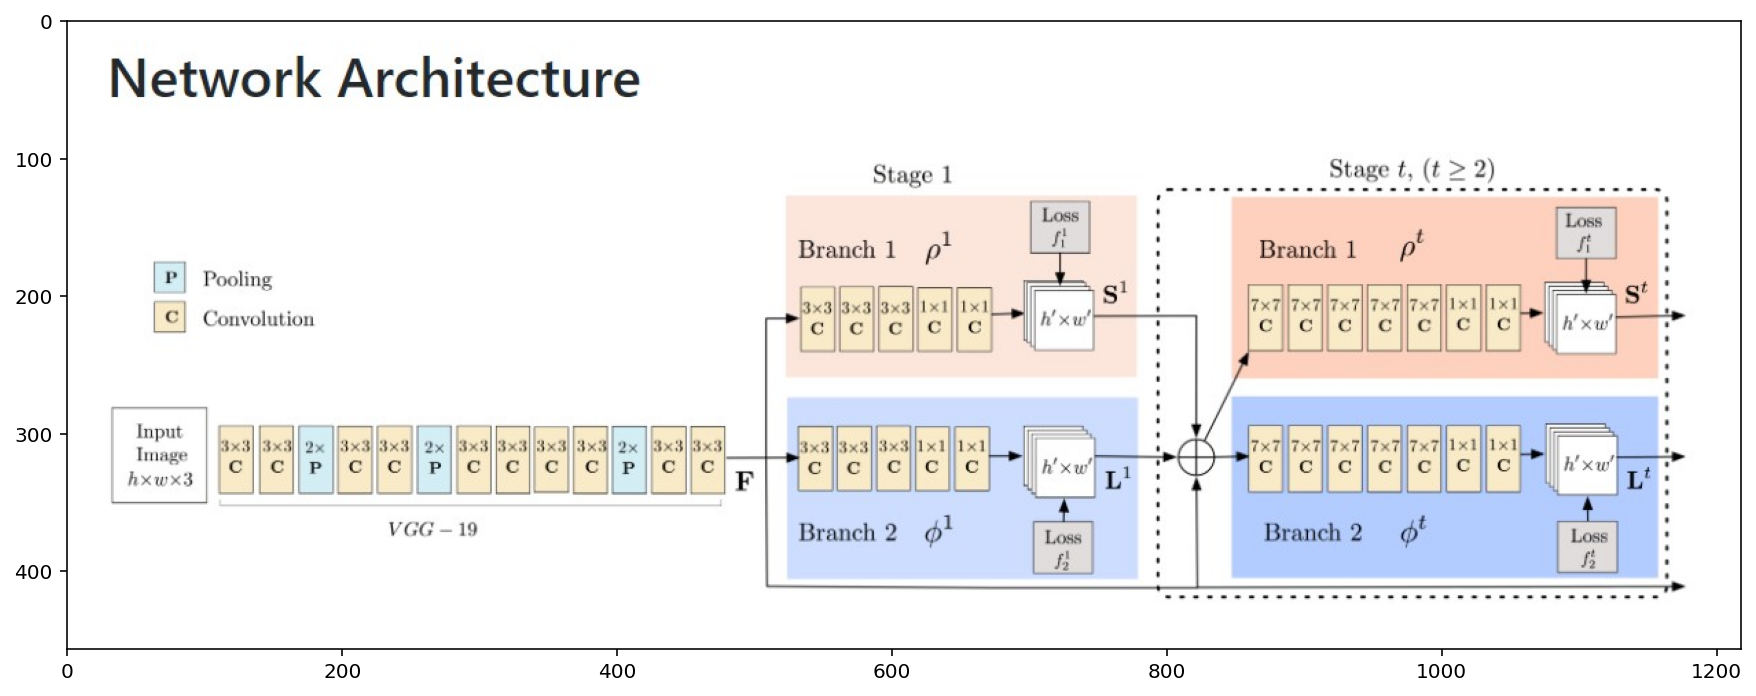

In [5]:
arch_image = '../input/pose-estimation-test-images/architecture.jpg'
img_ori = cv2.imread(arch_image)
plt.figure(figsize=(15, 8))
plt.imshow(img_ori[...,::-1])

Notice, the first 10 layers are from VGG-19. But here instead of downloading the model and loading the layers from there, we simply hardcoaded it in get_pose_model()

In [6]:
# Run this to view the model's architecture
#model_pose.eval()

In [7]:
use_gpu = True

if use_gpu:
    model_pose.cuda()
    model_pose = torch.nn.DataParallel(model_pose, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

In [8]:
def estimate_pose(img_ori):
    
    # People might be at different scales in the image, perform inference at multiple scales to boost results
    scale_param = [0.5, 1.0, 1.5, 2.0]
    
    # Predict Heatmaps for approximate joint position
    # Use Part Affinity Fields (PAF's) as guidance to link joints to form skeleton
    # PAF's are just unit vectors along the limb encoding the direction of the limb
    # A dot product of possible joint connection will be high if actual limb else low
    
    paf_info, heatmap_info = get_paf_and_heatmap(model_pose, img_ori, scale_param)
    peaks = extract_heatmap_info(heatmap_info)
    sp_k, con_all = extract_paf_info(img_ori, paf_info, peaks)
    
    subsets, candidates = get_subsets(con_all, sp_k, peaks)
    subsets, img_points = draw_key_point(subsets, peaks, img_ori)
    
    # After predicting Heatmaps and PAF's, proceeed to link joints correctly
    img_canvas = link_key_point(img_points, candidates, subsets)
    
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_points[...,::-1])
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_canvas[...,::-1])

torch.Size([1, 38, 23, 12])
torch.Size([1, 19, 23, 12])
torch.Size([1, 38, 46, 24])
torch.Size([1, 19, 46, 24])
torch.Size([1, 38, 69, 36])
torch.Size([1, 19, 69, 36])
torch.Size([1, 38, 92, 48])
torch.Size([1, 19, 92, 48])


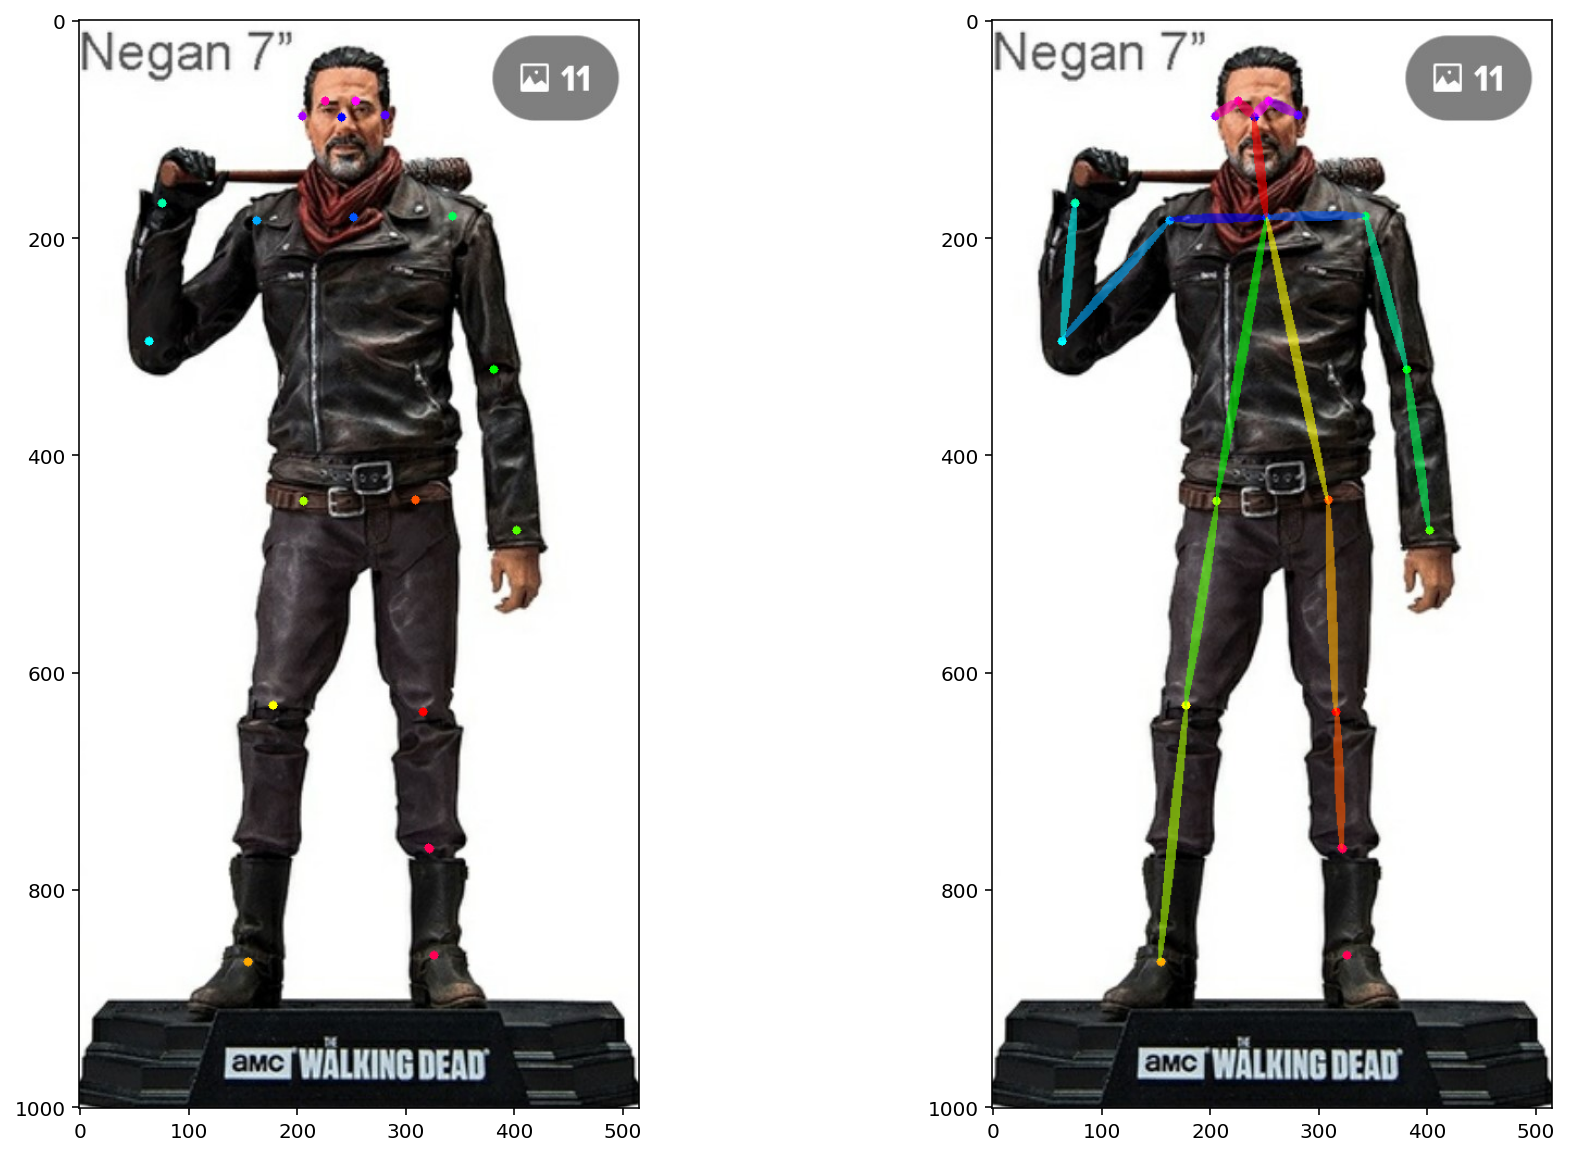

In [9]:
test_image = '../input/pose-estimation-test-images/Screenshot_20200421-155554_Wishh.jpg'
img_ori = cv2.imread(test_image)
estimate_pose(img_ori)

torch.Size([1, 38, 23, 27])
torch.Size([1, 19, 23, 27])
torch.Size([1, 38, 46, 54])
torch.Size([1, 19, 46, 54])
torch.Size([1, 38, 69, 81])
torch.Size([1, 19, 69, 81])
torch.Size([1, 38, 92, 107])
torch.Size([1, 19, 92, 107])


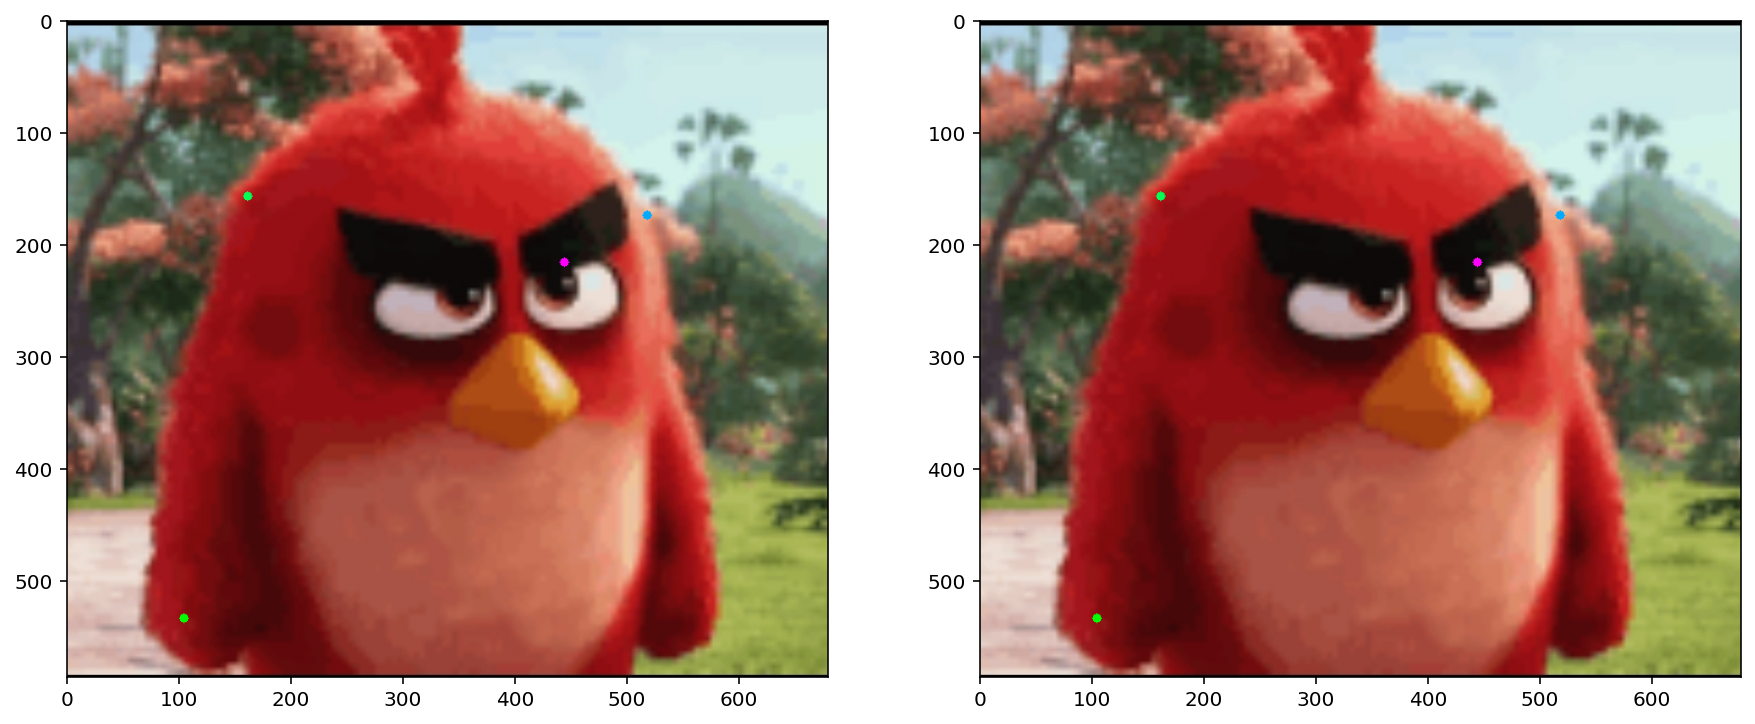

In [10]:
test_image = '../input/pose-estimation-test-images/Screenshot_20200623-062005_WhatsApp.jpg'
img_ori = cv2.imread(test_image)
estimate_pose(img_ori)

Detecting 4 features...

torch.Size([1, 38, 23, 14])
torch.Size([1, 19, 23, 14])
torch.Size([1, 38, 46, 27])
torch.Size([1, 19, 46, 27])
torch.Size([1, 38, 69, 40])
torch.Size([1, 19, 69, 40])
torch.Size([1, 38, 92, 54])
torch.Size([1, 19, 92, 54])


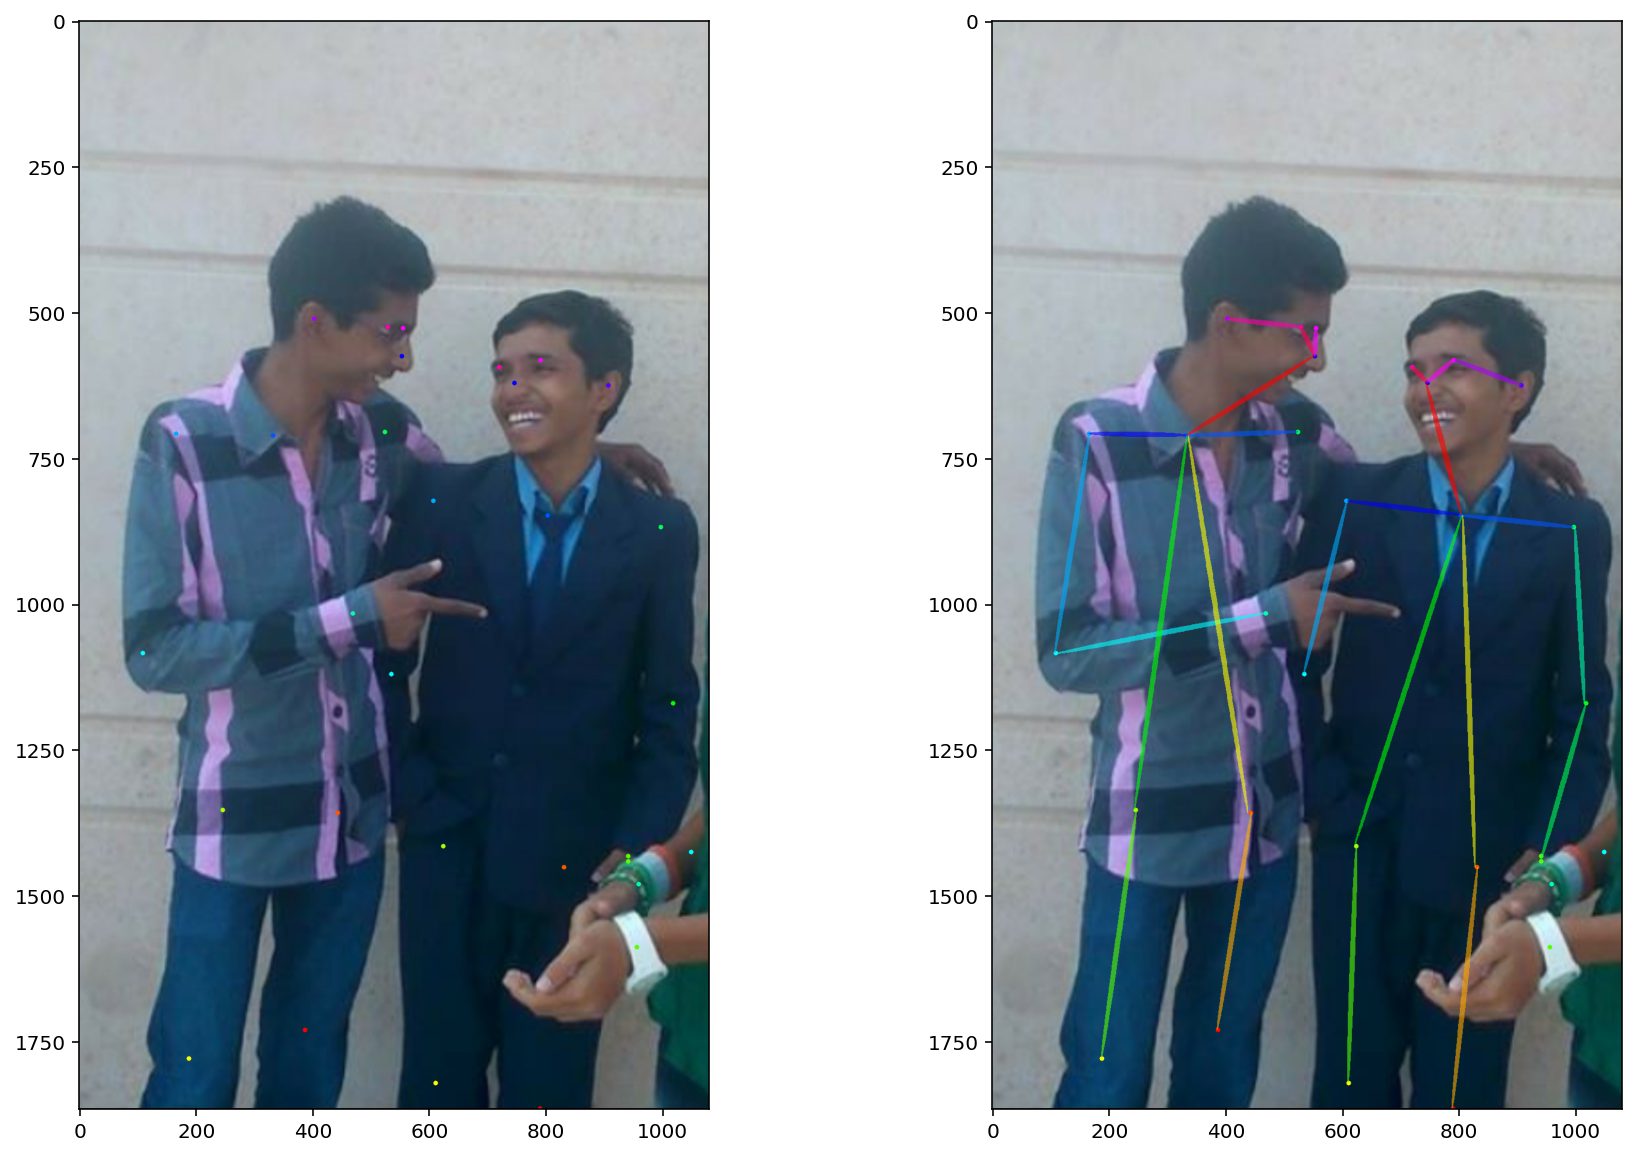

In [11]:
test_image = '../input/pose-estimation-test-images/Screenshot_20200322-200133_Files.jpg'
img_ori = cv2.imread(test_image)
estimate_pose(img_ori)

torch.Size([1, 38, 23, 50])
torch.Size([1, 19, 23, 50])
torch.Size([1, 38, 46, 100])
torch.Size([1, 19, 46, 100])
torch.Size([1, 38, 69, 150])
torch.Size([1, 19, 69, 150])
torch.Size([1, 38, 92, 200])
torch.Size([1, 19, 92, 200])


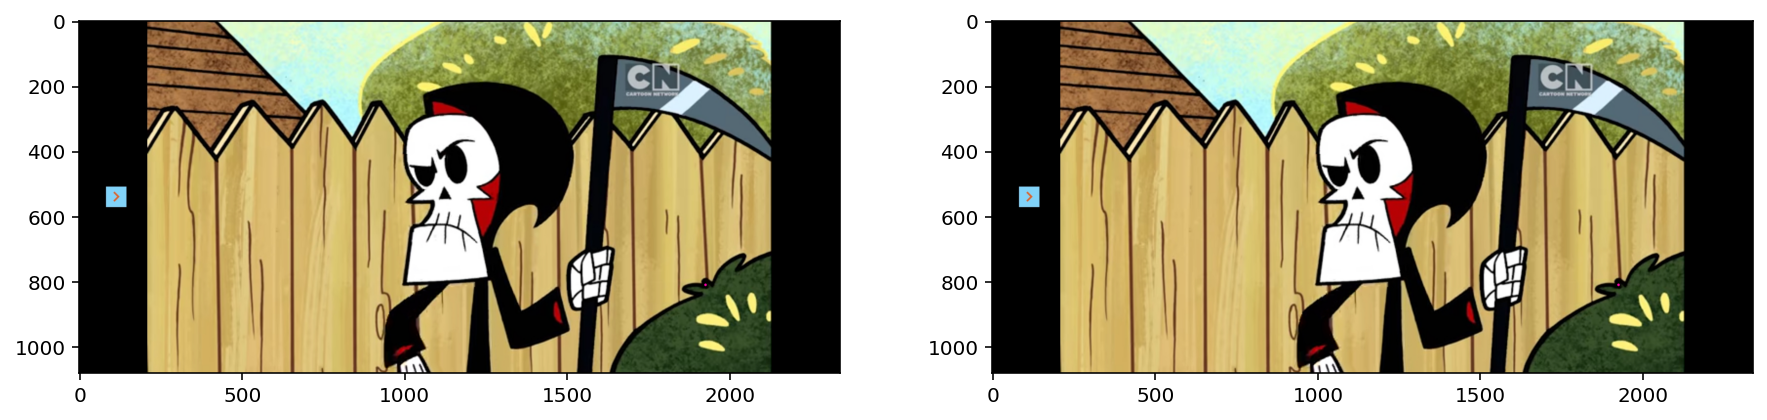

In [12]:
test_image = '../input/pose-estimation-test-images/Screenshot_20200526-200305_YouTube.jpg'
img_ori = cv2.imread(test_image)
estimate_pose(img_ori)

Nooooo nothing for Grim!

torch.Size([1, 38, 23, 46])
torch.Size([1, 19, 23, 46])
torch.Size([1, 38, 46, 92])
torch.Size([1, 19, 46, 92])
torch.Size([1, 38, 69, 138])
torch.Size([1, 19, 69, 138])
torch.Size([1, 38, 92, 184])
torch.Size([1, 19, 92, 184])


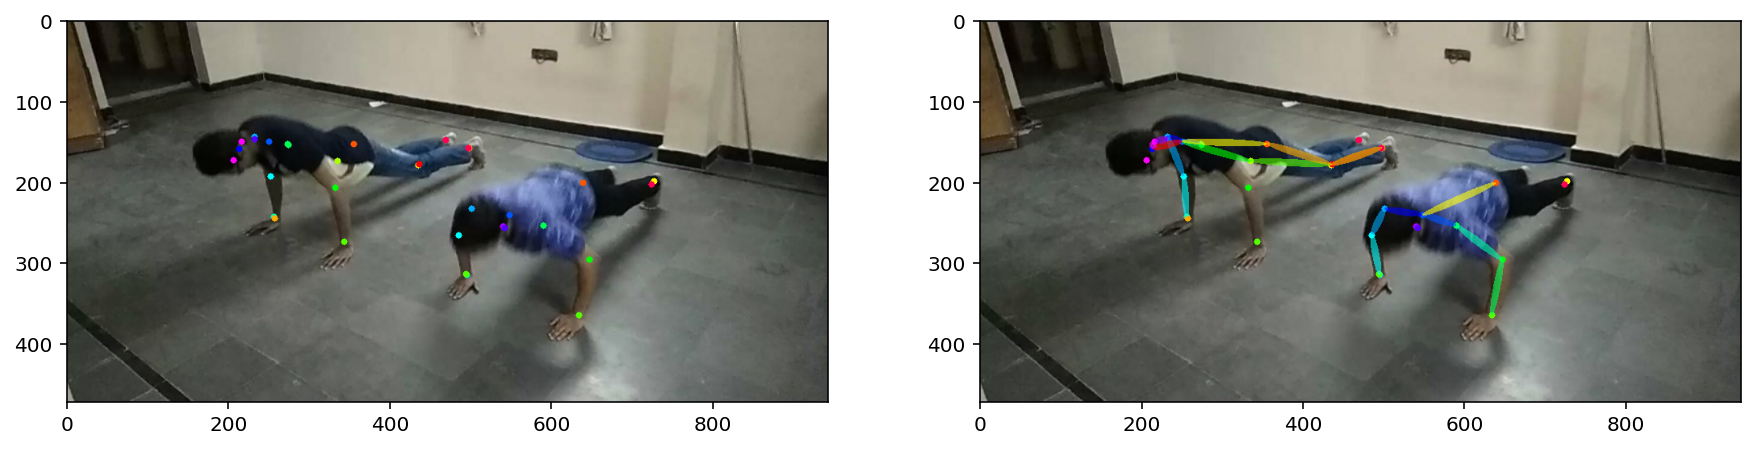

In [13]:
test_image = '../input/pose-estimation-test-images/20200317_114104.jpg'
img_ori = cv2.imread(test_image)
estimate_pose(img_ori)

Done. This is a very simple project. We simply used a pre-trained model. It was trained on the COCO dataset (250,000 people with keypoints - 42.7GB!)

I have more plans with this later. I want to fine-tune it for a particular use-case. Gotta learn that!

# Citation

@inproceedings{cao2017realtime,

  author = {Zhe Cao and Tomas Simon and Shih-En Wei and Yaser Sheikh},
  
  booktitle = {CVPR},
  
  title = {Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields},
  
  year = {2017}
 
 }